### Exercise 1

1) Load the breast_cancer dataset from skelarn (from sklearn.datasets import load_breast_cancer). Split the dataset into training and test datasets. Scale the dataset using minmaxscaler. Use KNeighborsClassifier classifier and report the score on the test dataset.

In [14]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = load_breast_cancer()
df = data.data
target = data.target
X_train, X_test, y_train, y_test = train_test_split(df, target, random_state= 0)

In [15]:
scaler = MinMaxScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)


In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train_scale, y_train)

print(f'MinMaxScaled Test Score: {knn.score(X_test_scale, y_test):.4f}')

MinMaxScaled Test Score: 0.9580


2) Repeat Step 1 using pipelines and report the score.

In [26]:
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    MinMaxScaler(),
    KNeighborsClassifier(n_neighbors=3))
pipe.fit(X_train, y_train)
print(f"Train score: {pipe.score(X_train, y_train):.4f}")
print(f"Test score: {pipe.score(X_test, y_test):.4f}")

Train score: 0.9812
Test score: 0.9510


3) Use the pipeline object from Step 2 and make a grid search on parameter of number of neighbor. 

In [28]:
pipe

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=3))])

In [40]:
from sklearn.model_selection import GridSearchCV


param_grid = {'kneighborsclassifier__n_neighbors':  np.arange(1, 30, 2)}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=10,return_train_score=True)
grid.fit(X_train, y_train)

print(f"best mean cross-validation score: {grid.best_score_:.3f}")
print(f"best parameters: {grid.best_params_:}")
print(f"test-set score: {grid.score(X_test, y_test):.3f}")

best mean cross-validation score: 0.970
best parameters: {'kneighborsclassifier__n_neighbors': np.int64(5)}
test-set score: 0.958


4)	Import bike_day_raw.csv. Create a pipeline using ColumnTransformer, Scaling, and KNeighborsRegressor.

- Use `from sklearn.neighbors import KNeighborsRegressor'
- You need to split the data into X and y. 
- Check the data shape
- Check the data types
- Print the column names of the data frame
- Create a scatterplot of each feature against the target variable (you may use clues our previous labs to do that)
- Create alist of features that are numeric and not numeric
- Create a pipeline of imputer and standard scaler for the numeric features
- Create a column transformer which uses the pipeline you created for numeric features and a onehotencoder for the non-numeric features
- You can create your column transformer in different ways
- Finally create a pipeline of column transformer and kNeighborsRegressor
- Split your data into train and test datasets
- Report the score on the test dataset



In [90]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline



df_bike = pd.read_csv('bike_day_raw.csv')

df_bike.head()

,season,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,1,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,1,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,1,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,1,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


In [52]:
X = df_bike.drop(columns = 'cnt')
y = df_bike['cnt']

In [65]:
# First 6 columns are categorical

categorical = X.dtypes == 'int64'
numerical = X.dtypes == 'float64'
X.columns[categorical]
X.isnull().any()
# X.iloc[:, 0:6]

season        False
mnth          False
holiday       False
weekday       False
workingday    False
weathersit    False
temp          False
atemp         False
hum           False
windspeed     False
dtype: bool

In [79]:
X.shape

(731, 10)

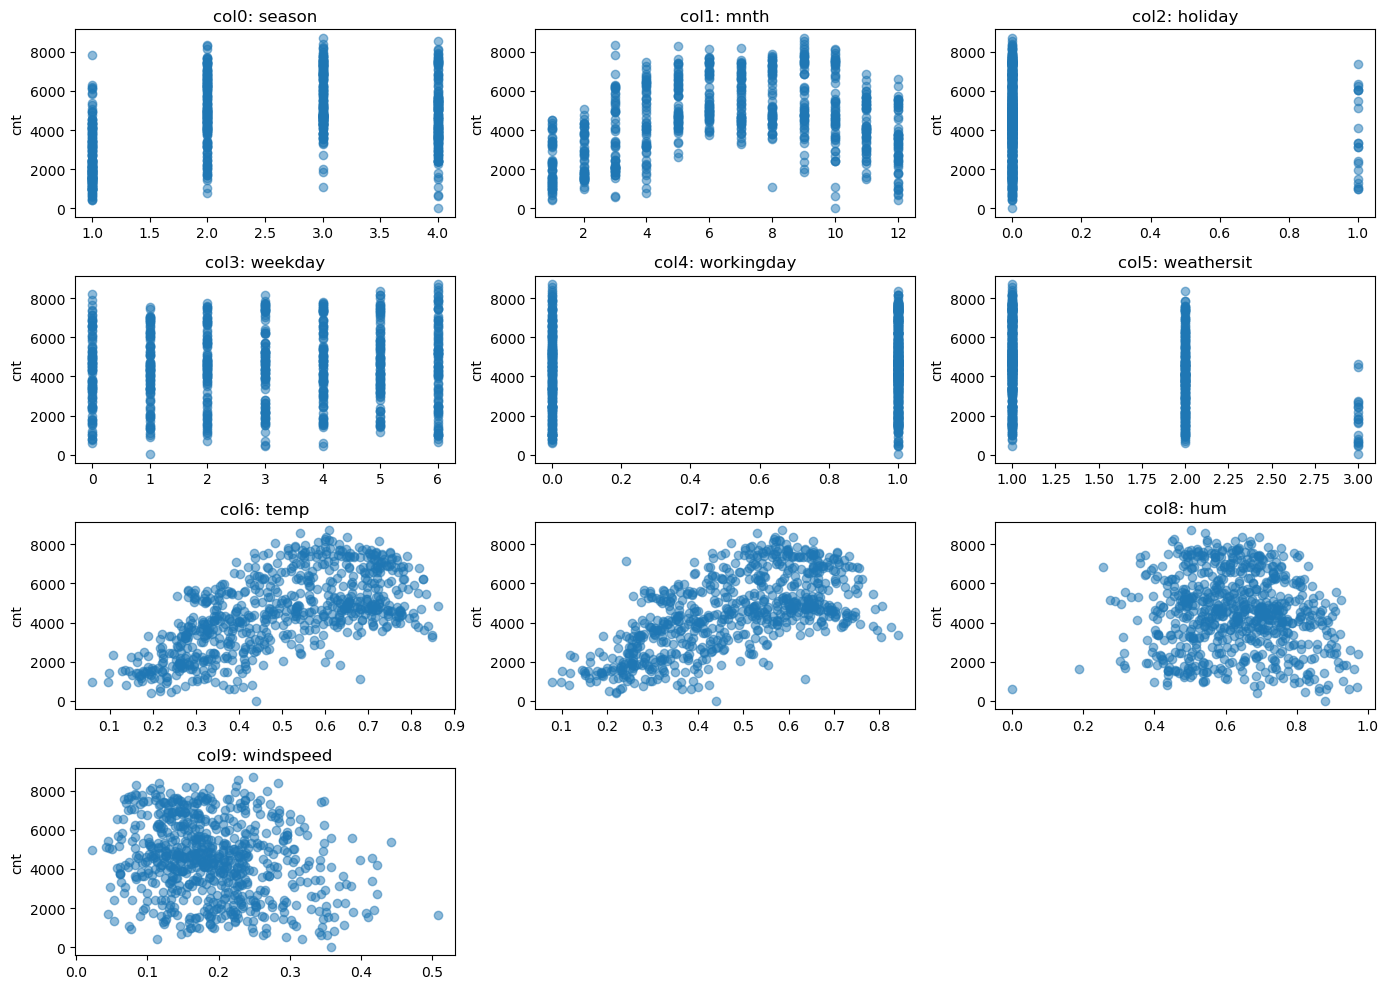

In [83]:
fig, axes = plt.subplots(4,3, figsize = (14,10))

for i, ax in enumerate(axes.ravel()):
    if i > 9:
        ax.set_visible(False)
        continue
    ax.scatter(X.iloc[:,i], y, alpha = .5)
    ax.set_title(f'col{i}: {X.columns[i]}')
    ax.set_ylabel("cnt")

plt.tight_layout()

In [84]:
# Use make_column_transformer
num_pipe = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)

preproc1 = make_column_transformer(
    (num_pipe, numerical),
    (OneHotEncoder(categories='auto'), categorical)
)

preproc2 = ColumnTransformer([
    ('num', num_pipe, numerical),
    ('categorical_coder', OneHotEncoder(categories='auto'), categorical)
])



In [86]:
model1 = make_pipeline(preproc1, KNeighborsRegressor())

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=24)
model1.fit(X_train, y_train)
print(f"KNeighborsRegressor regression score: {model1.score(X_test, y_test):.3f}")

KNeighborsRegressor regression score: 0.511


In [91]:
model2 = Pipeline([('preprocessor2', preproc2),
          ('regressor', KNeighborsRegressor())])

model2.fit(X_train, y_train)
print(f"KNeighborsRegressor regression score: {model2.score(X_test, y_test):.3f}")

KNeighborsRegressor regression score: 0.511


In [102]:
# CV grid search:
model2.get_params().keys()
grid = GridSearchCV(model2, param_grid={'regressor__n_neighbors': range(1,10)})
grid.fit(X_train, y_train)
grid.best_estimator_
# grid.score(X_test, y_test)

Pipeline(steps=[('preprocessor2',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  season        False
mnth          False
holiday       False
weekday       False
workingday    False
weathersit    False
temp           True
atemp          True
hum            True
windspeed      True
dtype: bool),
                                                 ('categorical_coder',
                                                  OneHotEncoder(),
                                                  season         True
mnth           True
holiday        True
weekday        True
workingday     True
weathersit     True
temp          False
atemp         False
hum           False
windspeed     False
dtype: bool)])),
                ('regressor', KNeighborsRegressor(n_neighbors=8))])

ColumnTransformer: a pipeline-style compiler that only covers preprocessing steps.  
Pipeline: cover all steps, up to model definition (before data training)  
grid: if using grid search, it's best to use ColumnTransformer & Pipeline instead of make_xxx functions, for customizable step names.